In [1]:
from __future__ import annotations

from flamekit.io_fields import field_path
from flamekit.io_fronts import Case
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydmd import DMD

# (Optional) keep MPI if you run on cluster; not needed for reading CSVs
from mpi4py import MPI

# Input Parameters
# ============================================================

TIME_STEP_START = 200
TIME_STEP_END = 300

PHI = 0.40
LAT_SIZE = "025"
POST = True

BASE_DIR = Path("../isocontours")  # where extracted_field[_post]_{t}.csv were saved

VAR_NAME = "T"  # field to run DMD on
SORT_COLS = ["x", "y"]  # stable ordering key for the state vector
COORD_TOL = 0.0  # set to >0 (e.g. 1e-12) if you want tolerance checks

# Cropping: keep only points with x > X_THESHOLD
X_THESHOLD = 300.0


# Helpers: locate + read the FULL FIELD CSV (NO iso)
# ============================================================

def field_csv_path(base_dir: Path, phi: float, lat_size: str, time_step: int, post: bool) -> Path:
    case = Case(
        base_dir=base_dir,
        phi=phi,
        lat_size=lat_size,
        time_step=time_step,
        post=post,
    )
    return field_path(case)

def read_field_sorted(path: Path, var_name: str, sort_cols: list[str]) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns:
      coords: (n_points, len(sort_cols)) array of coordinates (sorted)
      values: (n_points,) array of var_name values (sorted same way)
    """
    if not path.exists():
        raise FileNotFoundError(f"Missing file:\n  {path}")

    df = pd.read_csv(path)

    missing = [c for c in (sort_cols + [var_name]) if c not in df.columns]
    if missing:
        raise ValueError(f"{path.name}: missing columns {missing}")

    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=sort_cols + [var_name])
    df = df.sort_values(sort_cols, kind="mergesort").reset_index(drop=True)

    coords = df[sort_cols].to_numpy(dtype=np.float64)
    values = df[var_name].to_numpy(dtype=np.float64)
    return coords, values


# Build snapshot matrix X for DMD (NO interpolation)
# ============================================================

comm = MPI.COMM_WORLD
rank = comm.rank

times = list(range(TIME_STEP_START, TIME_STEP_END + 1))

# Read reference timestep (FULL, then build mask from it)
ref_path = field_csv_path(BASE_DIR, PHI, LAT_SIZE, times[0], POST)
coords_ref_full, snap0_full = read_field_sorted(ref_path, VAR_NAME, SORT_COLS)

# Apply x-threshold mask ONCE, then apply same mask to all timesteps
x_ref = coords_ref_full[:, 0]
mask_x = x_ref > X_THESHOLD

coords_ref = coords_ref_full[mask_x]
snap0 = snap0_full[mask_x]

n_points = coords_ref.shape[0]
n_snapshots = len(times)

if rank == 0:
    print(f"Reference timestep: {times[0]}")
    print(f"X_THESHOLD={X_THESHOLD} -> keeping {n_points}/{coords_ref_full.shape[0]} points")
    print(f"n_points={n_points}, n_snapshots={n_snapshots}")
    print(f"Reading: {ref_path}")

snapshots = [snap0]

# Read remaining timesteps, verify identical FULL coordinates, then apply same mask
for t in times[1:]:
    path = field_csv_path(BASE_DIR, PHI, LAT_SIZE, t, POST)
    coords_t_full, snap_t_full = read_field_sorted(path, VAR_NAME, SORT_COLS)

    if coords_t_full.shape[0] != coords_ref_full.shape[0]:
        raise ValueError(
            f"Inconsistent number of points (full) at timestep {t}: {coords_t_full.shape[0]} vs {coords_ref_full.shape[0]}.\n"
            f"Interpolation (or re-meshing to a common grid) would be required."
        )

    # Coordinate consistency check on FULL coords
    if COORD_TOL == 0.0:
        same = np.array_equal(coords_t_full, coords_ref_full)
    else:
        same = np.allclose(coords_t_full, coords_ref_full, atol=COORD_TOL, rtol=0.0)

    if not same:
        raise ValueError(
            f"Coordinates do not match reference at timestep {t}.\n"
            f"Set COORD_TOL>0 to allow tolerance, or use interpolation onto a common grid."
        )

    # Apply same mask
    snap_t = snap_t_full[mask_x]
    snapshots.append(snap_t)

# Snapshot matrix: shape (n_state, n_snapshots)
X = np.stack(snapshots, axis=1)
if rank == 0:
    print("X shape:", X.shape)

# DMD
# ============================================================

dmd = DMD()
dmd.fit(X)


Reference timestep: 200
X_THESHOLD=300.0 -> keeping 255744/839680 points
n_points=255744, n_snapshots=101
Reading: ../isocontours/phi0.40/h400x025_ref/extracted_field_post_200.csv
X shape: (255744, 101)


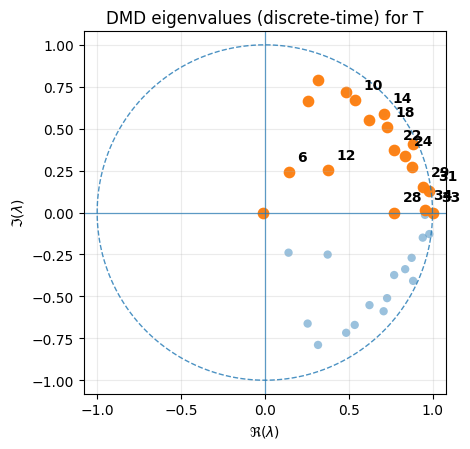

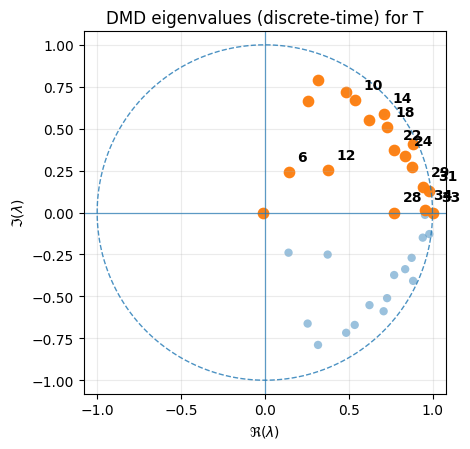

In [2]:

# Output directory (Windows)
OUT_DIR = Path(r"C:\Users\alexp\Documents\Bachelor Thesis\report_figures\results\DMD\h_025")
OUT_DIR.mkdir(parents=True, exist_ok=True)
import numpy as np
import matplotlib.pyplot as plt

def plot_dmd_eigs_report(
    dmd,
    VAR_NAME="field",
    OUT_DIR=None,          # pathlib.Path or None
    stem="dmd_eigs_complex_plane",
    label_top_n=12,        # label only the most "important" modes to avoid clutter
    MODE_IMAG_TOL=1e-10,
    use_amp_rms_for_labels=True,
):
    lam = np.asarray(dmd.eigs, dtype=complex)

    # Optional importance metric for labeling
    if use_amp_rms_for_labels and hasattr(dmd, "dynamics"):
        dyn = np.asarray(dmd.dynamics)
        amp_rms = np.sqrt(np.mean(np.abs(dyn) ** 2, axis=1))
    else:
        amp_rms = np.ones(len(lam))

    # Keep one per conjugate pair: real + upper half-plane
    indices_keep = []
    for i, li in enumerate(lam):
        if li.imag > MODE_IMAG_TOL:
            indices_keep.append(i)
        elif abs(li.imag) <= MODE_IMAG_TOL:
            indices_keep.append(i)
    indices_keep = np.array(indices_keep, dtype=int)

    # Choose which indices to annotate (top-N by amp_rms among kept)
    order = indices_keep[np.argsort(amp_rms[indices_keep])[::-1]]
    idx_annot = order[:min(label_top_n, len(order))]

    fig = plt.figure(figsize=(7.2, 4.6))
    ax = fig.add_subplot(111)

    # Light grid
    ax.grid(True, alpha=0.25)

    # Unit circle
    theta = np.linspace(0, 2*np.pi, 400)
    ax.plot(np.cos(theta), np.sin(theta), linestyle="--", linewidth=1.0, alpha=0.8)

    # Axes lines
    ax.axhline(0.0, linewidth=0.9, alpha=0.7)
    ax.axvline(0.0, linewidth=0.9, alpha=0.7)

    # Plot all eigenvalues (light)
    ax.scatter(lam.real, lam.imag, s=36, alpha=0.45, edgecolors="none")

    # Highlight kept (one per conj. pair)
    ax.scatter(lam[indices_keep].real, lam[indices_keep].imag, s=55, alpha=0.95)

    # Annotate selected modes only (avoid clutter)
    for k in idx_annot:
        ax.annotate(
            f"{k+1}",
            (lam[k].real, lam[k].imag),
            textcoords="offset points",
            xytext=(6, 6),
            ha="left",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    ax.set_xlabel(r"$\Re(\lambda)$")
    ax.set_ylabel(r"$\Im(\lambda)$")
    ax.set_title(f"DMD eigenvalues (discrete-time) for {VAR_NAME}")
    ax.set_aspect("equal", adjustable="box")

    # Limits: slightly padded around points + unit circle
    rmax = max(1.0, np.max(np.abs(lam)) if len(lam) else 1.0)
    lim = 1.08 * rmax
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    fig.tight_layout()

    # Save if requested
    if OUT_DIR is not None:
        OUT_DIR.mkdir(parents=True, exist_ok=True)
        fig.savefig(OUT_DIR / f"{stem}.pdf")
        fig.savefig(OUT_DIR / f"{stem}.png", dpi=400)

    plt.show()
    return fig

# --- usage (consistent with your previous saving approach) ---
plot_dmd_eigs_report(
    dmd,
    VAR_NAME=VAR_NAME,
    OUT_DIR=OUT_DIR,  # same Path you used before
    stem=f"dmd_eigs_{VAR_NAME}",
    label_top_n=12
)


In [3]:
print("DMD eigenvalues:", dmd.eigs)
print("modes shape:", dmd.modes.shape)
print("dynamics shape:", dmd.dynamics.shape)


DMD eigenvalues: [-0.01304204+0.j          0.31709569+0.78959045j  0.31709569-0.78959045j
  0.2551065 +0.66219176j  0.2551065 -0.66219176j  0.14130998+0.23944623j
  0.14130998-0.23944623j  0.48491598+0.71720464j  0.48491598-0.71720464j
  0.53591641+0.67027055j  0.53591641-0.67027055j  0.37460499+0.25072909j
  0.37460499-0.25072909j  0.70831382+0.58872616j  0.70831382-0.58872616j
  0.62401961+0.55217656j  0.62401961-0.55217656j  0.72898006+0.51054362j
  0.72898006-0.51054362j  0.88418761+0.40758772j  0.88418761-0.40758772j
  0.77111544+0.37274306j  0.77111544-0.37274306j  0.83686252+0.33784029j
  0.83686252-0.33784029j  0.87549296+0.27025588j  0.87549296-0.27025588j
  0.77078249+0.j          0.94169658+0.14978932j  0.94169658-0.14978932j
  0.98088135+0.12846093j  0.98088135-0.12846093j  1.00051264+0.j
  0.95516613+0.0140621j   0.95516613-0.0140621j ]
modes shape: (255744, 35)
dynamics shape: (35, 101)


DT not provided; using dt = 1.0 (timestep units).
Total modes: 35
Modes kept (one per conj. pair): 19
Top modes (by amp_rms): [32, 33, 28, 30, 23, 21, 17, 27, 11, 13]


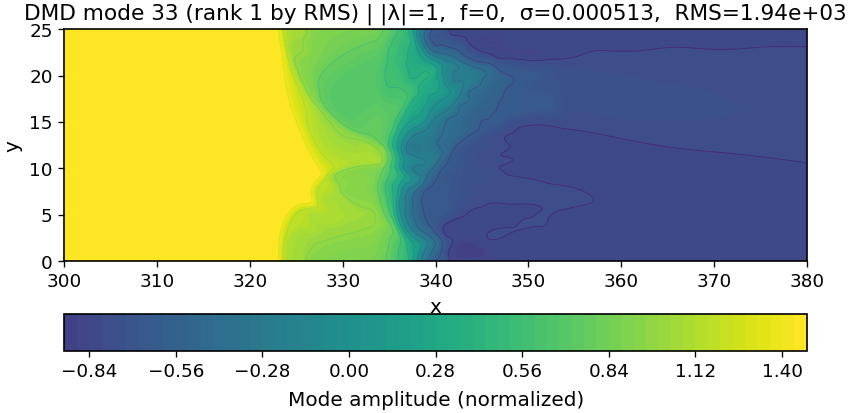

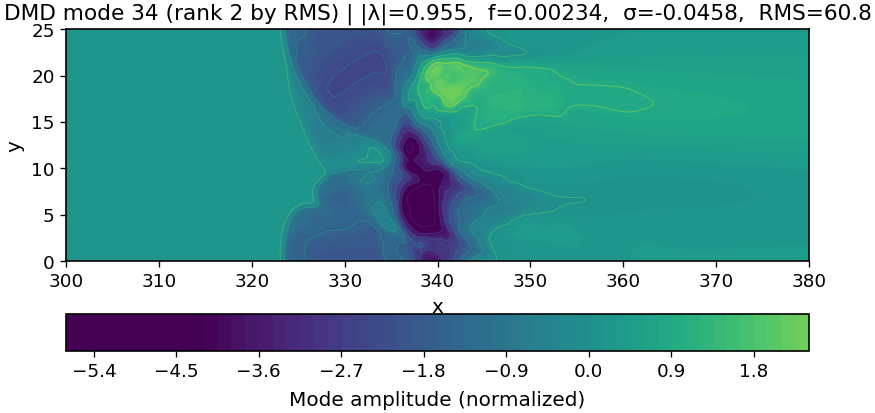

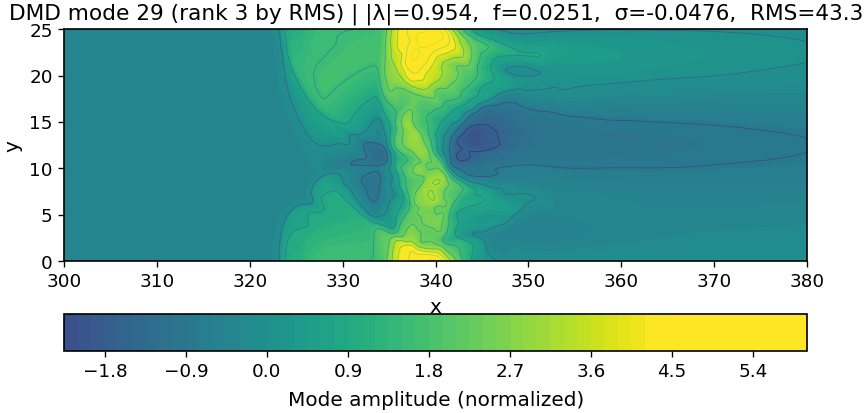

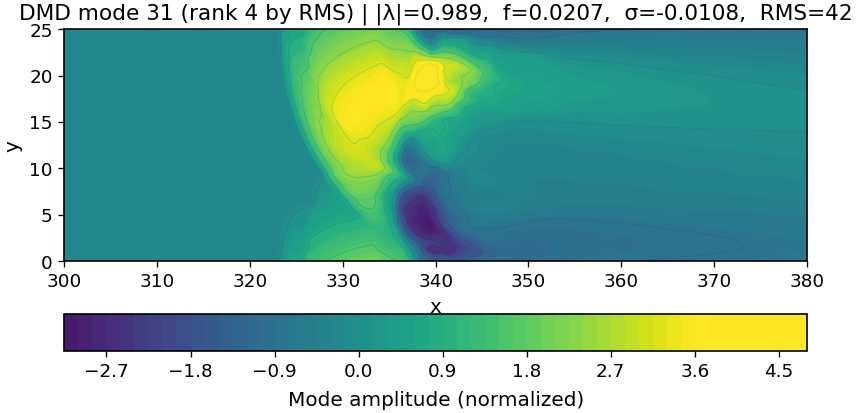

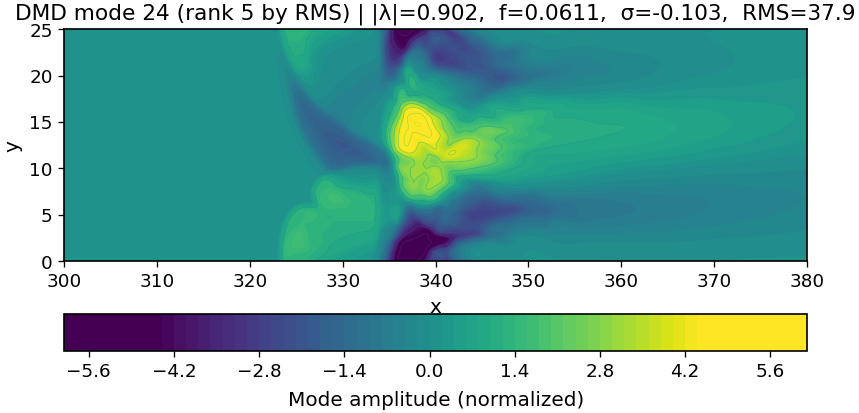

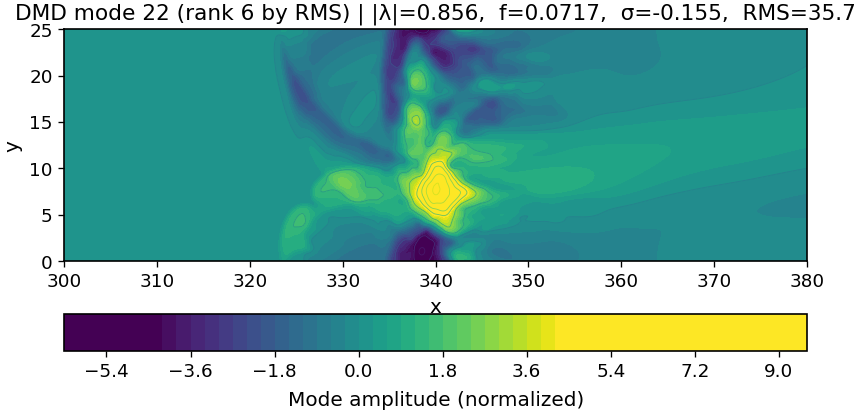

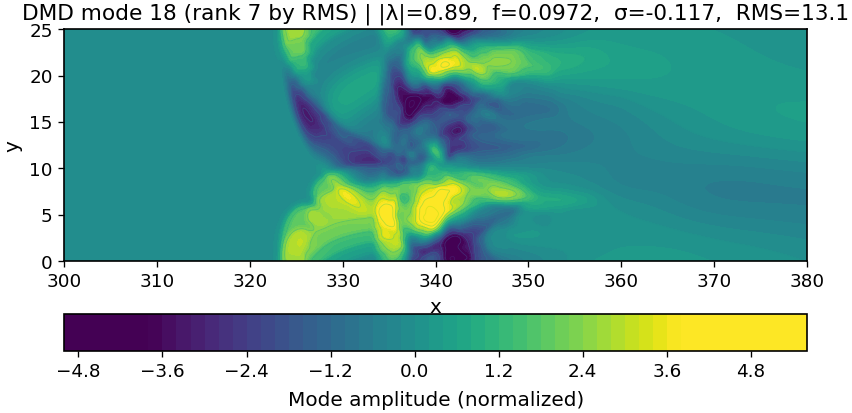

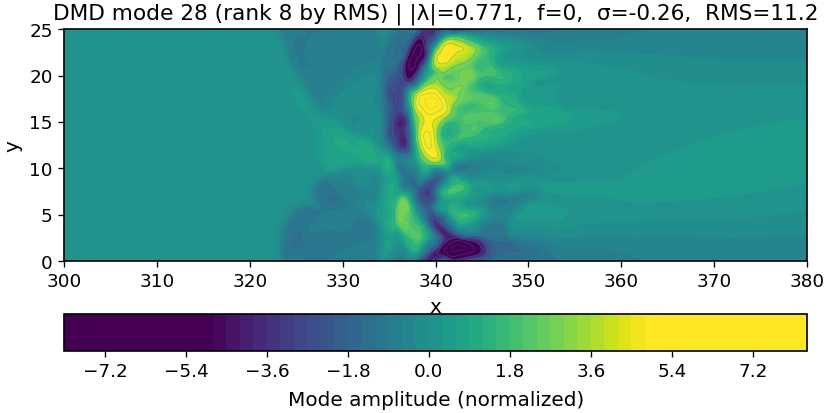

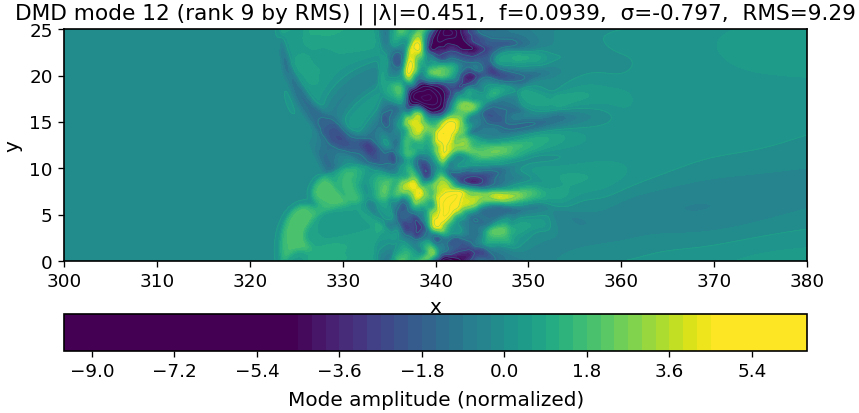

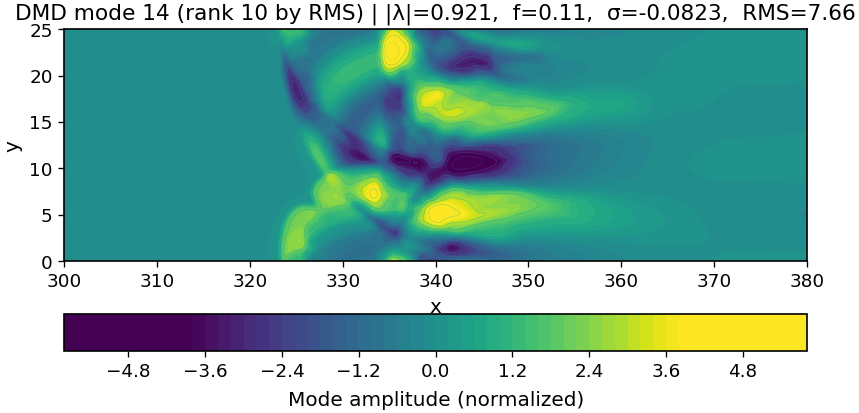

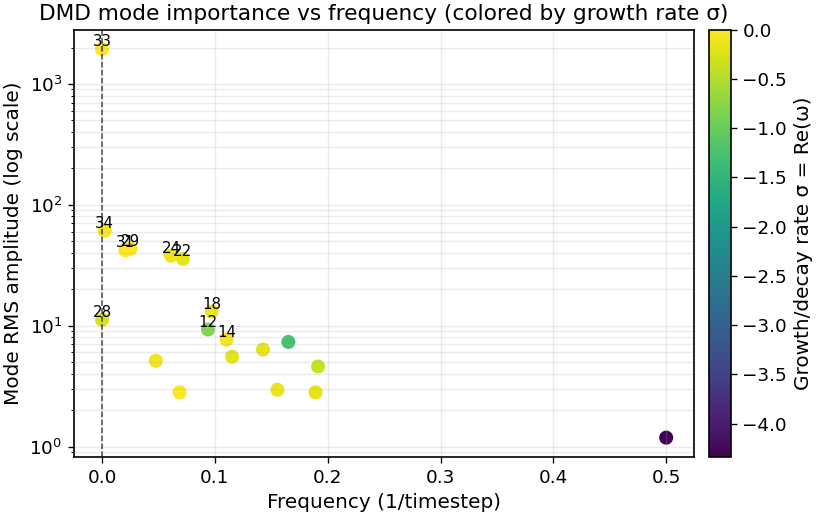

Top modes by RMS amplitude:
mode         freq        sigma      amp_rms     |lambda|
  33  0.00000e+00  5.12506e-04  1.94284e+03  1.00051e+00
  34  2.34293e-03 -4.57616e-02  6.07713e+01  9.55270e-01
  35 -2.34293e-03 -4.57616e-02  6.07713e+01  9.55270e-01
  30 -2.51054e-02 -4.75790e-02  4.32514e+01  9.53535e-01
  29  2.51054e-02 -4.75790e-02  4.32514e+01  9.53535e-01
  32 -2.07257e-02 -1.08006e-02  4.20065e+01  9.89258e-01
  31  2.07257e-02 -1.08006e-02  4.20065e+01  9.89258e-01
  24  6.10663e-02 -1.02606e-01  3.79336e+01  9.02483e-01
  25 -6.10663e-02 -1.02606e-01  3.79336e+01  9.02483e-01
  22  7.16619e-02 -1.54925e-01  3.57054e+01  8.56479e-01


In [4]:
# ============================================================
# DMD POST-PROCESSING PLOTS (adds to your "no interpolation" DMD workflow)
#   (1) Spatial plots of selected DMD modes (one per conj. pair)
#   (2) Mode RMS amplitude vs frequency (colored by growth rate)
#
# Assumptions:
#   - You already ran DMD: dmd.fit(X)
#   - You have "times" (sorted timesteps) and dt (physical spacing if known)
#   - You have a consistent point ordering across timesteps (same coords)
#   - You have coords_ref and (optionally) a dataframe for t0
# ============================================================

import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from pathlib import Path

# -------------------------
# USER SETTINGS
# -------------------------
DT = None  # set to physical dt if available (e.g., 1e-6). If None, uses timestep spacing.

MODE_IMAG_TOL = 1e-10
FREQ_TOL = 1e-12

N_MODES_TO_PLOT = 10
NORMALIZE_MODE_FOR_PLOT = True

CONTOUR_LEVELS_FILLED = 60
CONTOUR_LEVELS_LINES = 12

COORD_X = "x"
COORD_Y = "y"

# Optional zoom (set to None to disable)
XLIM = (300, 380)   # e.g. None
YLIM = None         # e.g. None



# -------------------------
# Matplotlib report style
# -------------------------
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 400,
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "axes.linewidth": 1.0,
    "lines.linewidth": 1.2,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.03,
})

def save_fig(fig, stem: str):
    """Save as PNG+PDF with consistent naming."""
    fig.savefig(OUT_DIR / f"{stem}.png")
    fig.savefig(OUT_DIR / f"{stem}.pdf")

# -------------------------
# (A) Get coordinates + triangulation
# -------------------------
if "coords_ref" in globals():
    x = coords_ref[:, 0].astype(float)
    y = coords_ref[:, 1].astype(float)
else:
    t0 = times[0]
    mask0 = front_all["timestep"] == t0
    x = front_all.loc[mask0, COORD_X].to_numpy(dtype=float)
    y = front_all.loc[mask0, COORD_Y].to_numpy(dtype=float)

if dmd.modes.shape[0] != len(x) or dmd.modes.shape[0] != len(y):
    raise ValueError(
        f"modes and coords misaligned: modes={dmd.modes.shape[0]}, x={len(x)}, y={len(y)}"
    )

tri = mtri.Triangulation(x, y)

# Mask very skinny triangles (helps avoid ugly artifacts)
try:
    analyzer = mtri.TriAnalyzer(tri)
    mask = analyzer.get_flat_tri_mask(min_circle_ratio=0.02)
    tri.set_mask(mask)
except Exception:
    pass

# -------------------------
# (B) Compute sigma, freq, mode RMS amplitudes
# -------------------------
if DT is None:
    dt = float(times[1] - times[0])
    print(f"DT not provided; using dt = {dt} (timestep units).")
else:
    dt = float(DT)
    print(f"Using provided DT = {dt} (physical time units).")

lam = dmd.eigs.astype(complex)
omega = np.log(lam) / dt
sigma = omega.real
freq = omega.imag / (2 * np.pi)

dyn = dmd.dynamics  # (n_modes, n_snapshots)
amp_rms = np.sqrt(np.mean(np.abs(dyn) ** 2, axis=1))

# Keep one per conjugate pair: real eigenvalues + upper half-plane complex
indices_keep = []
for i, lam_i in enumerate(lam):
    if lam_i.imag > MODE_IMAG_TOL:
        indices_keep.append(i)
    elif abs(lam_i.imag) <= MODE_IMAG_TOL:
        indices_keep.append(i)
indices_keep = np.array(indices_keep, dtype=int)

# Rank by importance (RMS amplitude) among kept modes
order_keep = indices_keep[np.argsort(amp_rms[indices_keep])[::-1]]
top_modes = order_keep[:min(N_MODES_TO_PLOT, len(order_keep))]

print("Total modes:", len(lam))
print("Modes kept (one per conj. pair):", len(indices_keep))
print("Top modes (by amp_rms):", top_modes.tolist())

# -------------------------
# (C) Spatial XY plots for the most important modes
# -------------------------
for rank, i in enumerate(top_modes, start=1):
    mode_vals = dmd.modes[:, i]
    mode_plot = mode_vals.real.astype(float)

    if NORMALIZE_MODE_FOR_PLOT:
        mode_plot = (mode_plot - mode_plot.mean()) / (mode_plot.std() + 1e-12)

    # Symmetric color limits (better for signed modal structures)
    vmax = np.percentile(np.abs(mode_plot), 99.0)
    if vmax <= 0:
        vmax = np.max(np.abs(mode_plot)) + 1e-12

    fig = plt.figure(figsize=(7.2, 6.3))
    ax = fig.add_subplot(111)

    cf = ax.tricontourf(tri, mode_plot, levels=CONTOUR_LEVELS_FILLED,
                        vmin=-vmax, vmax=vmax)
    ax.tricontour(tri, mode_plot, levels=CONTOUR_LEVELS_LINES,
                  linewidths=0.5, alpha=0.75)

    ax.set_xlabel(COORD_X)
    ax.set_ylabel(COORD_Y)
    ax.set_aspect("equal", adjustable="box")

    if XLIM is not None:
        ax.set_xlim(*XLIM)
    if YLIM is not None:
        ax.set_ylim(*YLIM)

    title = (
        f"DMD mode {i+1} (rank {rank} by RMS) | "
        f"|λ|={abs(lam[i]):.3g},  f={freq[i]:.3g},  σ={sigma[i]:.3g},  RMS={amp_rms[i]:.3g}"
    )
    ax.set_title(title)

    cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.08, fraction=0.06)
    cbar.set_label(
        "Mode amplitude (normalized)" if NORMALIZE_MODE_FOR_PLOT else "Mode amplitude",
        labelpad=6
    )


    fig.tight_layout()
    save_fig(fig, f"dmd_mode_rank{rank:02d}_mode{i+1:03d}")
    plt.show()

# -------------------------
# (D) Amplitude vs Frequency plot (report-style)
# -------------------------
# Keep freq >= 0 for plotting (collapse conjugates)
idx_plot = np.where(freq >= -FREQ_TOL)[0]
freq_plot = freq[idx_plot]
amp_plot = amp_rms[idx_plot]
sigma_plot = sigma[idx_plot]

fig = plt.figure(figsize=(7.2, 4.6))
ax = fig.add_subplot(111)

sc = ax.scatter(freq_plot, amp_plot, c=sigma_plot, s=55)
ax.axvline(0.0, color="k", linewidth=0.9, linestyle="--", alpha=0.7)

ax.set_yscale("log")  # usually clearer for mode amplitudes
ax.set_xlabel("Frequency (1/time units)" if DT is not None else "Frequency (1/timestep)")
ax.set_ylabel("Mode RMS amplitude (log scale)")
ax.set_title("DMD mode importance vs frequency (colored by growth rate σ)")
ax.grid(True, which="both", alpha=0.25)

# Annotate the top 10 (by RMS) among plotted indices
top_for_labels = idx_plot[np.argsort(amp_rms[idx_plot])[::-1][:10]]
for k in top_for_labels:
    j = np.where(idx_plot == k)[0][0]
    ax.text(freq_plot[j], amp_plot[j], f"{k+1}", fontsize=9, ha="center", va="bottom")

cbar = fig.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label("Growth/decay rate σ = Re(ω)")

fig.tight_layout()
save_fig(fig, "dmd_amp_vs_freq")
plt.show()

# -------------------------
# (E) Dominant modes table
# -------------------------
order_all = np.argsort(amp_rms)[::-1]
print("Top modes by RMS amplitude:")
print(f"{'mode':>4} {'freq':>12} {'sigma':>12} {'amp_rms':>12} {'|lambda|':>12}")
for k in order_all[:10]:
    print(f"{k+1:4d} {freq[k]:12.5e} {sigma[k]:12.5e} {amp_rms[k]:12.5e} {abs(lam[k]):12.5e}")


Unstable modes (|λ|>1): 1
Max |λ|: 1.0005126375211824
Wrote: ../isocontours/phi0.40/h400x025_ref/dmd_pred_T_301_xgt300.csv


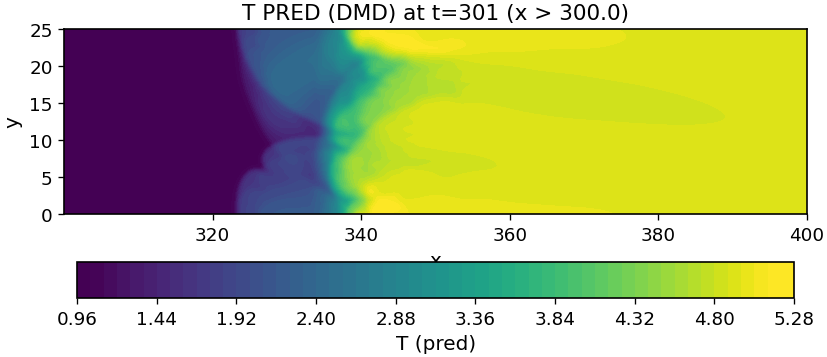

Next-step RMSE: 9.373774e-01
Next-step relative L2 error: 2.274735e-01
Wrote: ../isocontours/phi0.40/h400x025_ref/dmd_err_T_301_xgt300.csv


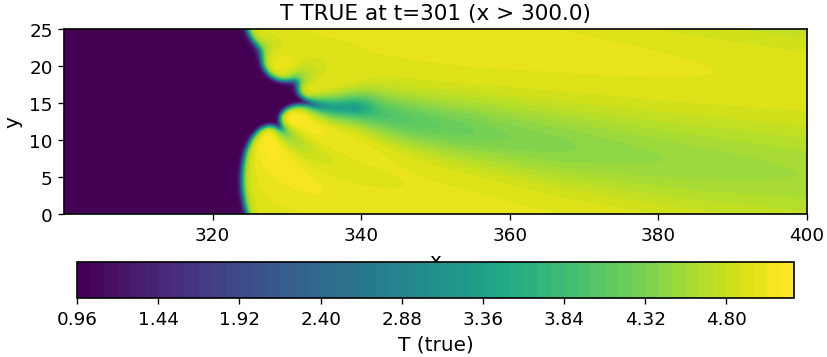

/tmp/ipykernel_205643/461118187.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


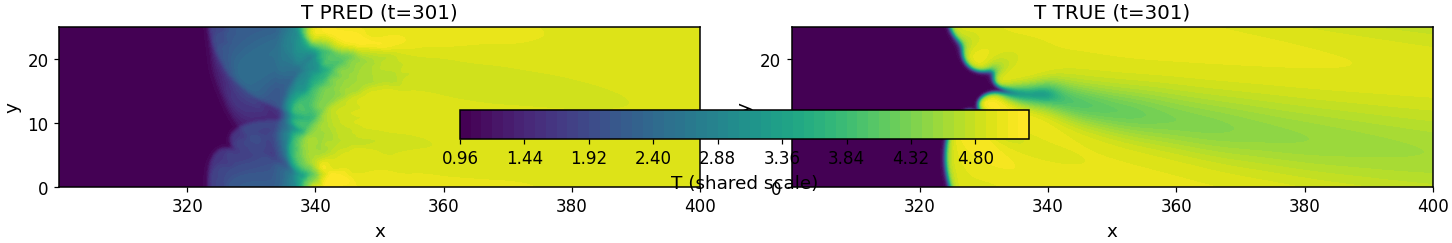

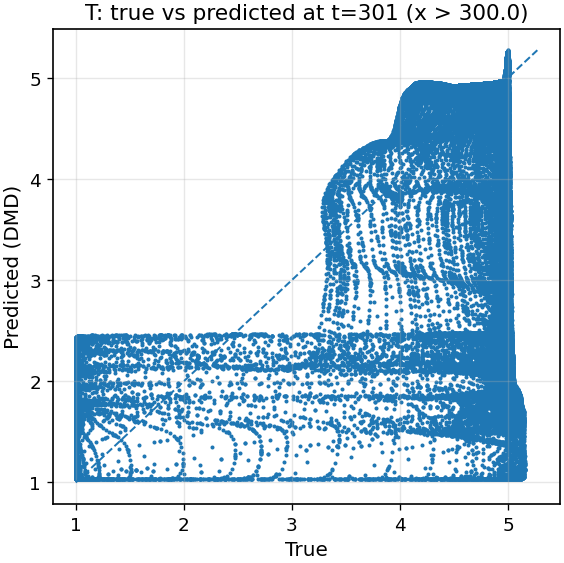

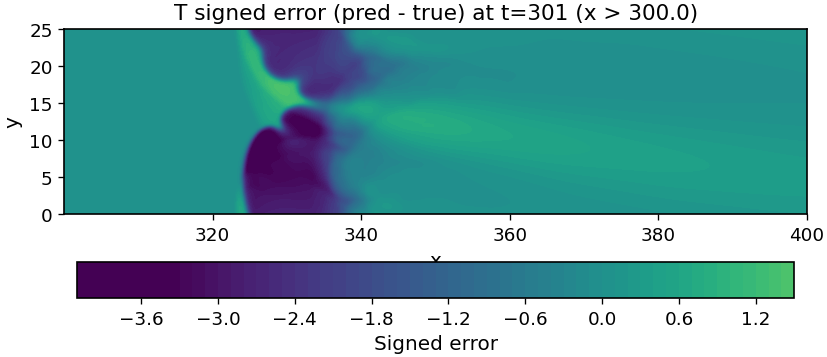

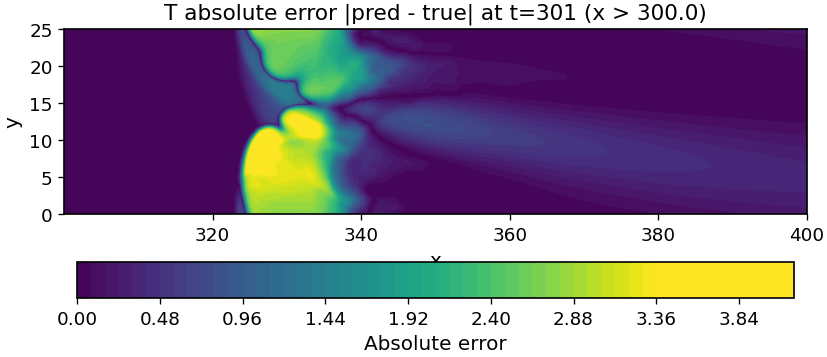

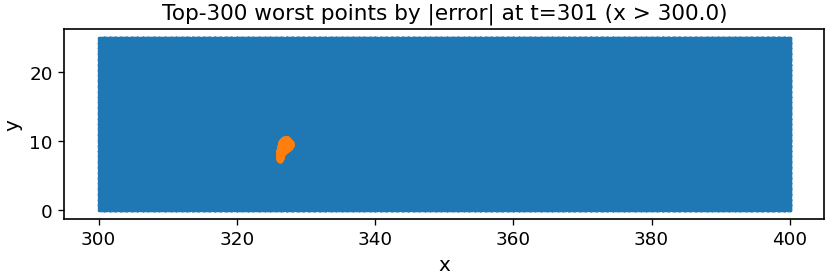

In [5]:
from flamekit.io_fields import field_path
from flamekit.io_fronts import Case
# ------------------------------------------------------------
# Forecast + save + compare (with CROPPED coords) + error maps
# + NEW: plots of predicted and true fields at next timestep
# ------------------------------------------------------------
# Assumptions:
# - dmd.fit(X) already called
# - X was built from cropped snapshots (mask_x applied)
# - coords_ref is cropped coords (mask_x applied), shape (n_points_cropped, 2)
# - coords_ref_full and mask_x exist from snapshot-building phase
# - helper functions exist: field_csv_path, read_field_sorted
# - constants exist: TIME_STEP_END, BASE_DIR, PHI, LAT_SIZE, POST, VAR_NAME, SORT_COLS, X_THESHOLD, COORD_TOL

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# ------------------------------------------------------------
# 1) Forecast next snapshot with consistent index-time
# ------------------------------------------------------------
n_train = X.shape[1]

# ✅ Modify keys (works when the property has no setter)
dmd.original_time["t0"]   = 0
dmd.original_time["tend"] = n_train - 1
dmd.original_time["dt"]   = 1.0

dmd.dmd_time["t0"]   = 0
dmd.dmd_time["tend"] = n_train          # +1 step forecast
dmd.dmd_time["dt"]   = 1.0

X_rec = dmd.reconstructed_data          # shape: (n_points_cropped, n_train+1)
x_next_pred = np.asarray(X_rec[:, -1]).real

# Optional diagnostic: eigenvalue stability
lam = np.asarray(dmd.eigs, dtype=complex)
print("Unstable modes (|λ|>1):", int(np.sum(np.abs(lam) > 1.0)))
print("Max |λ|:", float(np.max(np.abs(lam))))

# ------------------------------------------------------------
# 2) Save prediction alongside coordinates (CROPPED)
# ------------------------------------------------------------
t_next = TIME_STEP_END + 1  # keep consistent everywhere

out = pd.DataFrame(coords_ref, columns=SORT_COLS)
out[f"{VAR_NAME}_pred"] = x_next_pred

out_dir = field_path(Case(base_dir=BASE_DIR, phi=PHI, lat_size=LAT_SIZE, time_step=0, post=POST)).parent
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / f"dmd_pred_{VAR_NAME}_{t_next}_xgt{int(X_THESHOLD)}.csv"
out.to_csv(out_path, index=False)
print("Wrote:", out_path)

# ------------------------------------------------------------
# 3) Build triangulation ONCE for CROPPED coords (for all XY maps)
# ------------------------------------------------------------
x = coords_ref[:, 0].astype(float)
y = coords_ref[:, 1].astype(float)
tri = mtri.Triangulation(x, y)

# Optional: mask skinny triangles (helps avoid artifacts)
try:
    analyzer = mtri.TriAnalyzer(tri)
    mask = analyzer.get_flat_tri_mask(min_circle_ratio=0.02)
    tri.set_mask(mask)
except Exception:
    pass

# ------------------------------------------------------------
# 3A) Plot PREDICTED field at next timestep (always available)
# ------------------------------------------------------------
vmax_pred = np.percentile(np.abs(x_next_pred), 99.5) + 1e-30
vmin_pred = np.percentile(x_next_pred, 0.5)
vmax_pred_lin = np.percentile(x_next_pred, 99.5)

fig = plt.figure(figsize=(7.2, 5.8))
ax = fig.add_subplot(111)
cf = ax.tricontourf(tri, x_next_pred, levels=60, vmin=vmin_pred, vmax=vmax_pred_lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"{VAR_NAME} PRED (DMD) at t={t_next} (x > {X_THESHOLD})")
cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.08, fraction=0.06)
cbar.set_label(f"{VAR_NAME} (pred)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3B) Compare to true next snapshot + error metrics + plots
# ------------------------------------------------------------
path_true = field_csv_path(BASE_DIR, PHI, LAT_SIZE, t_next, POST)

if path_true.exists():
    # Read TRUE snapshot FULL first
    coords_true_full, snap_true_full = read_field_sorted(path_true, VAR_NAME, SORT_COLS)

    # Coordinate check on FULL coords (prevents false mismatch due to masking)
    if coords_true_full.shape[0] != coords_ref_full.shape[0]:
        raise ValueError(
            f"True next-step has different full point count: {coords_true_full.shape[0]} vs {coords_ref_full.shape[0]}"
        )

    if COORD_TOL == 0.0:
        same = np.array_equal(coords_true_full, coords_ref_full)
    else:
        same = np.allclose(coords_true_full, coords_ref_full, atol=COORD_TOL, rtol=0.0)

    if not same:
        raise ValueError(
            "Full coordinates changed; cannot compare directly. "
            "Sorting / interpolation mismatch or mesh changed."
        )

    # Apply SAME mask as training data
    snap_true = snap_true_full[mask_x]

    if snap_true.shape[0] != coords_ref.shape[0] or snap_true.shape[0] != x_next_pred.shape[0]:
        raise RuntimeError("Cropped true snapshot size does not match prediction size. Check mask_x usage.")

    err = x_next_pred - snap_true
    abs_err = np.abs(err)

    rmse = float(np.sqrt(np.mean(err**2)))
    rel_l2 = float(np.linalg.norm(err) / (np.linalg.norm(snap_true) + 1e-30))
    print(f"Next-step RMSE: {rmse:.6e}")
    print(f"Next-step relative L2 error: {rel_l2:.6e}")

    # Save error CSV for later inspection (CROPPED)
    out_err = pd.DataFrame(coords_ref, columns=SORT_COLS)
    out_err[f"{VAR_NAME}_true"] = snap_true
    out_err[f"{VAR_NAME}_pred"] = x_next_pred
    out_err["err"] = err
    out_err["abs_err"] = abs_err
    err_path = out_dir / f"dmd_err_{VAR_NAME}_{t_next}_xgt{int(X_THESHOLD)}.csv"
    out_err.to_csv(err_path, index=False)
    print("Wrote:", err_path)

    # --------------------------------------------------------
    # NEW: Plot TRUE field at next timestep, using SAME color scale as PRED
    # --------------------------------------------------------
    vmin = float(min(np.percentile(snap_true, 0.5), np.percentile(x_next_pred, 0.5)))
    vmax = float(max(np.percentile(snap_true, 99.5), np.percentile(x_next_pred, 99.5)))

    fig = plt.figure(figsize=(7.2, 5.8))
    ax = fig.add_subplot(111)
    cf = ax.tricontourf(tri, snap_true, levels=60, vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"{VAR_NAME} TRUE at t={t_next} (x > {X_THESHOLD})")
    cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.08, fraction=0.06)
    cbar.set_label(f"{VAR_NAME} (true)")
    plt.tight_layout()
    plt.show()

    # Optional: a side-by-side figure (pred vs true) with shared limits
    fig, axes = plt.subplots(1, 2, figsize=(13.5, 5.6), dpi=110)
    cf0 = axes[0].tricontourf(tri, x_next_pred, levels=60, vmin=vmin, vmax=vmax)
    axes[0].set_aspect("equal", adjustable="box")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    axes[0].set_title(f"{VAR_NAME} PRED (t={t_next})")

    cf1 = axes[1].tricontourf(tri, snap_true, levels=60, vmin=vmin, vmax=vmax)
    axes[1].set_aspect("equal", adjustable="box")
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    axes[1].set_title(f"{VAR_NAME} TRUE (t={t_next})")

    cbar = fig.colorbar(cf1, ax=axes.ravel().tolist(), orientation="horizontal", pad=0.10, fraction=0.06)
    cbar.set_label(f"{VAR_NAME} (shared scale)")
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------
    # Quick diagnostic scatter (true vs pred)
    # --------------------------------------------------------
    plt.figure(figsize=(5, 5))
    plt.scatter(snap_true, x_next_pred, s=2)
    lo = float(min(snap_true.min(), x_next_pred.min()))
    hi = float(max(snap_true.max(), x_next_pred.max()))
    plt.plot([lo, hi], [lo, hi], linestyle="--")
    plt.xlabel("True")
    plt.ylabel("Predicted (DMD)")
    plt.title(f"{VAR_NAME}: true vs predicted at t={t_next} (x > {X_THESHOLD})")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------
    # 4) XY maps of error (SIGNED + ABSOLUTE)
    # --------------------------------------------------------
    vmax_signed = np.percentile(np.abs(err), 99.0) + 1e-30
    vmax_abs = np.percentile(abs_err, 99.0) + 1e-30

    # Signed error map
    fig = plt.figure(figsize=(7.2, 5.8))
    ax = fig.add_subplot(111)
    cf = ax.tricontourf(tri, err, levels=60, vmin=-vmax_signed, vmax=vmax_signed)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"{VAR_NAME} signed error (pred - true) at t={t_next} (x > {X_THESHOLD})")
    cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.08, fraction=0.06)
    cbar.set_label("Signed error")
    plt.tight_layout()
    plt.show()

    # Absolute error map
    fig = plt.figure(figsize=(7.2, 5.8))
    ax = fig.add_subplot(111)
    cf = ax.tricontourf(tri, abs_err, levels=60, vmin=0.0, vmax=vmax_abs)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"{VAR_NAME} absolute error |pred - true| at t={t_next} (x > {X_THESHOLD})")
    cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.08, fraction=0.06)
    cbar.set_label("Absolute error")
    plt.tight_layout()
    plt.show()

    # Worst-points overlay (helps pinpoint locations)
    k = 300
    idx_worst = np.argsort(abs_err)[-k:]

    fig = plt.figure(figsize=(7.2, 5.8))
    ax = fig.add_subplot(111)
    ax.scatter(x, y, s=1)
    ax.scatter(x[idx_worst], y[idx_worst], s=8)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Top-{k} worst points by |error| at t={t_next} (x > {X_THESHOLD})")
    plt.tight_layout()
    plt.show()

else:
    print("True next-step file does not exist, so only the forecast was saved and the predicted field was plotted.")
